In [1]:
anger=0
disgust=1
fear=2
happy=3
sad=4
surprise=5
neutral=6

In [2]:
import itertools
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras import optimizers
from keras import Sequential
from keras import regularizers
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import VGG16, VGG19
from keras.layers import Flatten, Dropout, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
test_df = pd.read_csv('Data/test.csv')
train_df = pd.read_csv('Data/train.csv')
df = pd.read_csv('Data/fer2013.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [6]:
print(train_df.head())
print(test_df.head())

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3  205 203 236 157 83 158 120 116 94 86 155 180 2...
4  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


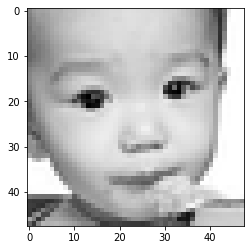

In [7]:
# View an image
i = 2000
list_pixels = np.array([int(string) for string in train_df.iloc[i,1].split(' ')])
pixeled_image = list_pixels.reshape(48,48)
plt.imshow(pixeled_image, cmap='gray');

## Base model (Dense)

In [8]:
# Split train data into x,y values for train and validation
x_train = []
for i in range(len(train_df)):
  list_pixels = [int(string) for string in train_df.iloc[i,1].split(' ')]
  x_train.append(list_pixels)
x = np.array(x_train)
y = train_df.iloc[:,0]

In [9]:
print(x)
print(y)


[[ 70  80  82 ... 106 109  82]
 [151 150 147 ... 193 183 184]
 [231 212 156 ...  88 110 152]
 ...
 [ 74  81  87 ... 188 187 187]
 [222 227 203 ... 136 136 134]
 [195 199 205 ...   6  15  38]]
0        0
1        0
2        2
3        4
4        6
        ..
28704    2
28705    0
28706    4
28707    0
28708    4
Name: emotion, Length: 28709, dtype: int64


In [10]:
# Categorize y to for compatiblity with softmax activation
from keras.utils import to_categorical
y_cat = to_categorical(np.array(y))

In [11]:
print(y_cat)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [12]:
# Train_test_split training data into training and testing sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y_cat, random_state = 123, test_size = 0.10)

In [13]:
print('x_test = ',x_test.shape)
print('y_test = ',y_test.shape)
print('training data  before splitting into train + validation :')
print('x_train1 = ',x_train1.shape)
print('y_train1 = ',y_train1.shape)

x_test =  (2871, 2304)
y_test =  (2871, 7)
training data  before splitting into train + validation :
x_train1 =  (25838, 2304)
y_train1 =  (25838, 7)


In [14]:
# Train_test_split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [15]:
print('x_train = ',x_train.shape)
print('y_train = ', y_train.shape)
print('x_val = ',x_val.shape)
print('y_val = ', y_val.shape)

x_train =  (20670, 2304)
y_train =  (20670, 7)
x_val =  (5168, 2304)
y_val =  (5168, 7)


### Building the model 

##### model : dense ,epoch : 50 

In [16]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model = models.Sequential()

In [17]:
# Add layers to model. 3 relus and one softmax
model.add(layers.Dense(256, activation='relu', input_shape=(2304,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax')) # need # of nodes to match # of classes

In [18]:
# look at categorical loss and use accuracy as metric with stochastic gradient descent as optimizer
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Like cross-validation
# Fit data to training set; use the validation set as a testing set for the batches 
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Train on 20670 samples, validate on 5168 samples
Epoch 1/15
20670/20670 [==============================] - 14s 670us/step - loss: nan - accuracy: 0.1389 - val_loss: nan - val_accuracy: 0.1395
Epoch 2/15
20670/20670 [==============================] - 11s 539us/step - loss: nan - accuracy: 0.1387 - val_loss: nan - val_accuracy: 0.1395
Epoch 3/15
20670/20670 [==============================] - 10s 464us/step - loss: nan - accuracy: 0.1387 - val_loss: nan - val_accuracy: 0.1395 accuracy: 
Epoch 4/15
20670/20670 [==============================] - 9s 451us/step - loss: nan - accuracy: 0.1387 - val_loss: nan - val_accuracy: 0.1395
Epoch 5/15
20670/20670 [==============================] - 9s 449us/step - loss: nan - accuracy: 0.1387 - val_loss: nan - val_accuracy: 0.1395
Epoch 6/15
20670/20670 [==============================] - 9s 450us/step - loss: nan - accuracy: 0.1387 - val_loss: nan - val_accuracy: 0.1395
Epoch 7/15
20670/20670 [==============================] - 9s 452us/step - loss: nan -

###### didn't need to go further  since accuracy is too low !!

## CNN trial 1

In [4]:
# Reshape 1D array to 2D matrix for Conv2D

x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers
  list_pixels = [int(string) for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)

x = np.array(x_train)
y = train_df.iloc[:,0]

In [21]:
print(x)
print(y)


[[[ 70  80  82 ...  52  43  41]
  [ 65  61  58 ...  56  52  44]
  [ 50  43  54 ...  49  56  47]
  ...
  [ 91  65  42 ...  72  56  43]
  [ 77  82  79 ... 105  70  46]
  [ 77  72  84 ... 106 109  82]]

 [[151 150 147 ... 129 140 120]
  [151 149 149 ... 122 141 137]
  [151 151 156 ... 109 123 146]
  ...
  [188 188 121 ... 185 185 186]
  [188 187 196 ... 186 182 187]
  [186 184 185 ... 193 183 184]]

 [[231 212 156 ...  44  27  16]
  [229 175 148 ...  27  35  27]
  [214 156 157 ...  28  22  28]
  ...
  [241 245 250 ...  57 101 146]
  [246 250 252 ...  78 105 162]
  [250 251 250 ...  88 110 152]]

 ...

 [[ 74  81  87 ... 189 191 192]
  [ 78  82  89 ... 185 189 193]
  [ 81  86  94 ... 176 185 193]
  ...
  [ 90  99 113 ... 192 195 197]
  [ 88  96 114 ... 192 194 192]
  [ 88  97 110 ... 188 187 187]]

 [[222 227 203 ... 138 132 122]
  [222 226 203 ... 142 136 127]
  [222 225 206 ... 147 143 129]
  ...
  [179 180 177 ... 141 139 137]
  [188 182 176 ... 138 136 135]
  [181 168 155 ... 136 136 1

In [5]:
# Categorize y for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [6]:
print(y)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [7]:

print('x - shape = ',x.shape) 
print('y shape = ' ,y.shape)

x - shape =  (28709, 48, 48)
y shape =  (28709, 7)


In [8]:

# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, random_state = 123, test_size = 0.10)

In [9]:
print('x_test = ',x_test.shape)
print('y_test = ',y_test.shape)
print('training data  before splitting into train + validation :')
print('x_train1 = ',x_train1.shape)
print('y_train1 = ',y_train1.shape)

x_test =  (2871, 48, 48)
y_test =  (2871, 7)
training data  before splitting into train + validation :
x_train1 =  (25838, 48, 48)
y_train1 =  (25838, 7)


In [10]:
# Train_test_split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [11]:
print('x_train = ',x_train.shape)
print('y_train = ', y_train.shape)
print('x_val = ',x_val.shape)
print('y_val = ', y_val.shape)

x_train =  (20670, 48, 48)
y_train =  (20670, 7)
x_val =  (5168, 48, 48)
y_val =  (5168, 7)


In [12]:
# Reshape the data  for x_train and x_val
# respectively. need to do this because input_shape in model_cnn.add needs a 2D image with 
# depth specified as 1
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)

In [13]:
print(x_train_reshaped.shape) 
print(x_val_reshaped.shape) 
print(x_test_reshaped.shape) 

(20670, 48, 48, 1)
(5168, 48, 48, 1)
(2871, 48, 48, 1)


### model

In [14]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model_cnn = models.Sequential()

#### tanh , softmax, cnn, batch size 100, epoch 100, no early callback, 4 layers, non standarized

In [15]:
model_cnn.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2),
                 activation='tanh',
                   input_shape=(48,48,1))) # kernel size = filter window size. 32 = number of output channels
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_cnn.add(Conv2D(64, (5, 5), activation='tanh'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='tanh'))
model_cnn.add(layers.Dense(7, activation='softmax')) # 7 classifications

In [16]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                

In [33]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [34]:
history_cnn = model_cnn.fit(x_train_reshaped,
                    y_train,
                    epochs=100, 
                    batch_size=100,
                    validation_data=(x_val_reshaped, y_val))

Train on 20670 samples, validate on 5168 samples
Epoch 1/100
20670/20670 [==============================] - 19s 905us/step - loss: 1.8229 - acc: 0.2418 - val_loss: 1.8090 - val_acc: 0.2550
Epoch 2/100
20670/20670 [==============================] - 17s 844us/step - loss: 1.7977 - acc: 0.2527 - val_loss: 1.8041 - val_acc: 0.2566
Epoch 3/100
20670/20670 [==============================] - 18s 850us/step - loss: 1.7808 - acc: 0.2655 - val_loss: 1.7816 - val_acc: 0.2705
Epoch 4/100
20670/20670 [==============================] - 18s 855us/step - loss: 1.7521 - acc: 0.2894 - val_loss: 1.7397 - val_acc: 0.3007
Epoch 5/100
20670/20670 [==============================] - 18s 850us/step - loss: 1.7310 - acc: 0.2983 - val_loss: 1.7433 - val_acc: 0.2841
Epoch 6/100
20670/20670 [==============================] - 18s 850us/step - loss: 1.7187 - acc: 0.3050 - val_loss: 1.7353 - val_acc: 0.2906
Epoch 7/100
20670/20670 [==============================] - 18s 849us/step - loss: 1.7132 - acc: 0.3099 - val_lo

In [35]:
print(history_cnn.history.keys())
epochs = range(1, len(history_cnn.history['loss']) + 1)
print(epochs)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
range(1, 101)


## plotting CNN trail - 1 

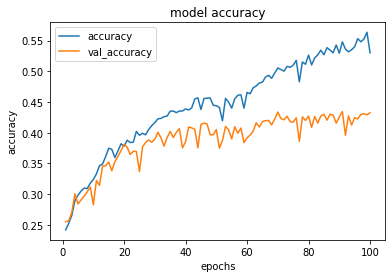

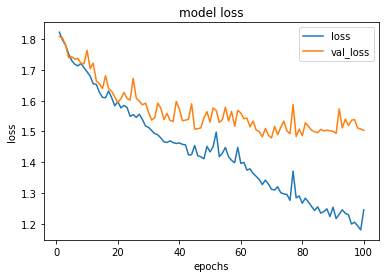

In [36]:
plt.plot(epochs,history_cnn.history['acc'])
plt.plot(epochs,history_cnn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(epochs,history_cnn.history['loss'])
plt.plot(epochs,history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

###  Test Model

In [37]:
#Results in form of [loss, accuracy]
results_train_cnn = model_cnn.evaluate(x_train_reshaped, y_train)
results_train_cnn

20670/20670 [==============================] - 6s 274us/step


[1.1379586915434647, 0.5850024223327637]

In [38]:
#Results in form [loss, accuracy]
results_test_cnn = model_cnn.evaluate(x_test_reshaped, y_test)
results_test_cnn

2871/2871 [==============================] - 1s 296us/step


[1.469479252884339, 0.445141077041626]

In [39]:
y_hat = model_cnn.predict(x_test_reshaped)

#### F1 score, recall and precision

In [40]:
def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate = []
  for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
  y_pred = np.array(y_hate)
  
  classification_metrics = classification_report(y_test, y_pred)
  print(classification_metrics)
  
  return y_pred,'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()


              precision    recall  f1-score   support

           0       0.37      0.32      0.34       407
           1       0.00      0.00      0.00        37
           2       0.30      0.25      0.27       399
           3       0.63      0.65      0.64       732
           4       0.33      0.38      0.35       494
           5       0.54      0.56      0.55       300
           6       0.40      0.43      0.41       502

   micro avg       0.45      0.45      0.45      2871
   macro avg       0.37      0.37      0.37      2871
weighted avg       0.44      0.45      0.44      2871
 samples avg       0.45      0.45      0.45      2871



(array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0]]),
 'F1: 0.4402400852732144',
 'precision: 0.43720037723770516',
 'recall: 0.445141065830721')

In [41]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


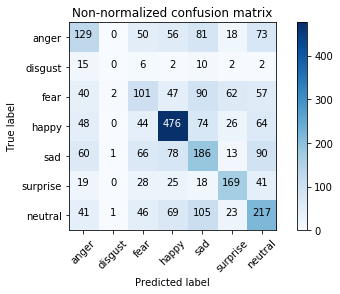

In [42]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_hat.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

## CNN trail 2

In [43]:
# Reshape 1D array to 2D matrix for Conv2D

x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers and standarize data
  list_pixels = [int(string)/255 for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)

x = np.array(x_train)
y = train_df.iloc[:,0]

In [44]:
# Categorize y for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [45]:
print(x.shape)
print(y.shape)

(28709, 48, 48)
(28709, 7)


In [46]:
# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, random_state = 123, test_size = 0.10)

In [47]:
print('x_test = ',x_test.shape)
print('y_test = ',y_test.shape)
print('training data  before splitting into train + validation :')
print('x_train1 = ',x_train1.shape)
print('y_train1 = ',y_train1.shape)

x_test =  (2871, 48, 48)
y_test =  (2871, 7)
training data  before splitting into train + validation :
x_train1 =  (25838, 48, 48)
y_train1 =  (25838, 7)


In [48]:
# Create train_test_split for validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [49]:
print('x_train = ',x_train.shape)
print('y_train = ', y_train.shape)
print('x_val = ',x_val.shape)
print('y_val = ', y_val.shape)

x_train =  (20670, 48, 48)
y_train =  (20670, 7)
x_val =  (5168, 48, 48)
y_val =  (5168, 7)


In [50]:
# Reshape the data  x_train and x_val
# respectively. need to do this because input_shape in model_cnn.add needs a 2D image with 
# depth specified as 1
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)

In [51]:
print(x_train_reshaped.shape) 
print(x_val_reshaped.shape) 
print(x_test_reshaped.shape) 

(20670, 48, 48, 1)
(5168, 48, 48, 1)
(2871, 48, 48, 1)


### model 

In [17]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model_cnn2 = models.Sequential()


##### standarized, 4 layers, cnn, tanh, softmax, batch size 10, epoch 30, early callback

In [18]:
model_cnn2.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2),
                 activation='tanh',
                   input_shape=(48,48,1))) # kernel size = filter window size. 32 = number of output channels

model_cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_cnn2.add(Conv2D(64, (5, 5), activation='tanh'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(layers.Flatten())
model_cnn2.add(layers.Dense(64, activation='tanh'))
model_cnn2.add(layers.Dense(7, activation='softmax'))

In [19]:
model_cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 22, 22, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                36928     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                

In [54]:
model_cnn2.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [55]:

earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=3,
                              verbose=0, mode='auto')

In [56]:
history_cnn2 = model_cnn2.fit(x_train_reshaped,
                    y_train,
                    epochs=35,
                    batch_size=10,
                    validation_data=(x_val_reshaped, y_val), callbacks= [earlystop])

Train on 20670 samples, validate on 5168 samples
Epoch 1/35
20670/20670 [==============================] - 37s 2ms/step - loss: 1.7725 - acc: 0.2710 - val_loss: 1.7061 - val_acc: 0.3119
Epoch 2/35
20670/20670 [==============================] - 31s 1ms/step - loss: 1.6370 - acc: 0.3642 - val_loss: 1.6145 - val_acc: 0.3725
Epoch 3/35
20670/20670 [==============================] - 31s 1ms/step - loss: 1.5507 - acc: 0.4085 - val_loss: 1.5627 - val_acc: 0.3992
Epoch 4/35
20670/20670 [==============================] - 31s 2ms/step - loss: 1.4898 - acc: 0.4327 - val_loss: 1.5128 - val_acc: 0.4168
Epoch 5/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.4313 - acc: 0.4542 - val_loss: 1.4823 - val_acc: 0.4294
Epoch 6/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.3803 - acc: 0.4716 - val_loss: 1.4634 - val_acc: 0.4396
Epoch 7/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.3335 - acc: 0.4965 - val_loss: 1.4548 - val_acc:

### Testing 

In [59]:
#Results in form [loss, accuracy]
results_train_cnn = model_cnn2.evaluate(x_train_reshaped, y_train)
results_train_cnn

20670/20670 [==============================] - 6s 291us/step


[1.0073632380901238, 0.634494423866272]

In [60]:
#Results of train with CNN
results_train_cnn = model_cnn2.evaluate(x_test_reshaped, y_test)
results_train_cnn

2871/2871 [==============================] - 1s 335us/step


[1.375735697161649, 0.4952978193759918]

In [61]:
y_hat = model_cnn2.predict(x_test_reshaped)

In [62]:
print(history_cnn2.history.keys())
epochs = range(1, len(history_cnn2.history['loss']) + 1)
print(epochs)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
range(1, 14)


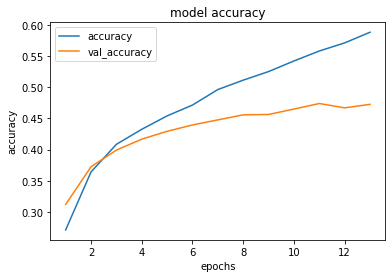

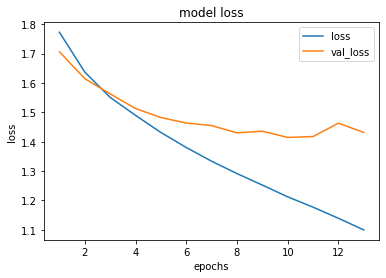

In [63]:
plt.plot(epochs,history_cnn2.history['acc'])
plt.plot(epochs,history_cnn2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(epochs,history_cnn2.history['loss'])
plt.plot(epochs,history_cnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [64]:
def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate = []
  for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
  y_pred = np.array(y_hate)
  
  classification_metrics = classification_report(y_test, y_pred)
  print(classification_metrics)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

              precision    recall  f1-score   support

           0       0.39      0.37      0.38       407
           1       0.33      0.03      0.05        37
           2       0.38      0.25      0.30       399
           3       0.65      0.72      0.69       732
           4       0.37      0.49      0.42       494
           5       0.60      0.55      0.57       300
           6       0.48      0.48      0.48       502

   micro avg       0.50      0.50      0.50      2871
   macro avg       0.46      0.41      0.41      2871
weighted avg       0.49      0.50      0.49      2871
 samples avg       0.50      0.50      0.50      2871



('F1: 0.48693389304151613',
 'precision: 0.4897426065427635',
 'recall: 0.4952978056426332')

Confusion matrix, without normalization


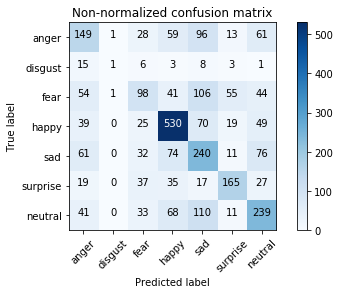

In [65]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_hat.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

## CNN trail - 3 

In [66]:
# Reshape 1D array to 2D matrix for Conv2D
x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers and standardize data
  list_pixels = [int(string)/255 for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)
  
x = np.array(x_train)
y = train_df.iloc[:,0]

In [69]:
# Categorize y to y category for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [70]:
print(x.shape) 
print(y.shape)

(28709, 48, 48)
(28709, 7)


In [71]:
# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, \
                                          random_state = 123, test_size = 0.10)

In [72]:
print('x_test = ',x_test.shape)
print('y_test = ',y_test.shape)
print('training data  before splitting into train + validation :')
print('x_train1 = ',x_train1.shape)
print('y_train1 = ',y_train1.shape)

x_test =  (2871, 48, 48)
y_test =  (2871, 7)
training data  before splitting into train + validation :
x_train1 =  (25838, 48, 48)
y_train1 =  (25838, 7)


In [73]:
# Create train_test_split for validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [74]:
print('x_train = ',x_train.shape)
print('y_train = ', y_train.shape)
print('x_val = ',x_val.shape)
print('y_val = ', y_val.shape)

x_train =  (20670, 48, 48)
y_train =  (20670, 7)
x_val =  (5168, 48, 48)
y_val =  (5168, 7)


In [75]:
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)

In [76]:
print(x_train_reshaped.shape)
print(x_val_reshaped.shape) 
print(x_test_reshaped.shape)

(20670, 48, 48, 1)
(5168, 48, 48, 1)
(2871, 48, 48, 1)


### model 

In [102]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model_cnn3 = models.Sequential()

##### increasing layer amount (1 more layer)

In [103]:
model_cnn3.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2),
                 activation='tanh',
                   input_shape=(48,48,1)))
# kernel size = filter window size
# 32 = number of output channels
# output is 45x45
model_cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_cnn3.add(Conv2D(64, (5, 5), activation='tanh'))
model_cnn3.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn3.add(Conv2D(128, (3, 3), activation='tanh'))
model_cnn3.add(MaxPooling2D(pool_size=(1, 1)))

model_cnn3.add(layers.Flatten())
model_cnn3.add(layers.Dense(64, activation='tanh'))
model_cnn3.add(layers.Dense(7, activation='softmax')) # 7 classifications

In [104]:
model_cnn3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 22, 22, 32)        832       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 1, 128)         73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)              

In [105]:
model_cnn3.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [106]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.005,
                              patience=3,
                              verbose=0, mode='auto')

In [107]:
history_cnn3 = model_cnn3.fit(x_train_reshaped,
                    y_train,
                    epochs=35,
                    batch_size=10,
                    validation_data=(x_val_reshaped, y_val), callbacks= [earlystop])

Train on 20670 samples, validate on 5168 samples
Epoch 1/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.7716 - acc: 0.2737 - val_loss: 1.6881 - val_acc: 0.3245
Epoch 2/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.6192 - acc: 0.3692 - val_loss: 1.6011 - val_acc: 0.3721
Epoch 3/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.5303 - acc: 0.4132 - val_loss: 1.5353 - val_acc: 0.4067
Epoch 4/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.4623 - acc: 0.4394 - val_loss: 1.4915 - val_acc: 0.4209
Epoch 5/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.4007 - acc: 0.4645 - val_loss: 1.4591 - val_acc: 0.4346
Epoch 6/35
20670/20670 [==============================] - 30s 1ms/step - loss: 1.3483 - acc: 0.4867 - val_loss: 1.4543 - val_acc: 0.4410
Epoch 7/35
20670/20670 [==============================] - 31s 1ms/step - loss: 1.2989 - acc: 0.5065 - val_loss: 1.4361 - val_acc:

### Test 

In [108]:
#Results in form [loss, accuracy]
results_train_cnn = model_cnn3.evaluate(x_train_reshaped, y_train)
results_train_cnn

20670/20670 [==============================] - 6s 284us/step


[1.0207718687929506, 0.6193033456802368]

In [109]:
#Results of train with CNN
results_train_cnn = model_cnn2.evaluate(x_test_reshaped, y_test)
results_train_cnn

2871/2871 [==============================] - 1s 300us/step


[1.375735697161649, 0.4952978193759918]

In [110]:
y_hat = model_cnn3.predict(x_test_reshaped)

In [111]:
print(history_cnn3.history.keys())
epochs = range(1, len(history_cnn3.history['loss']) + 1)
print(epochs)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
range(1, 12)


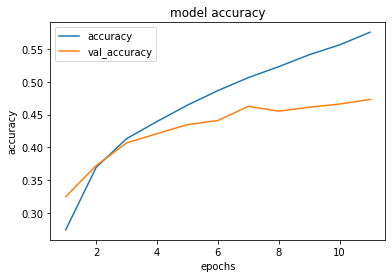

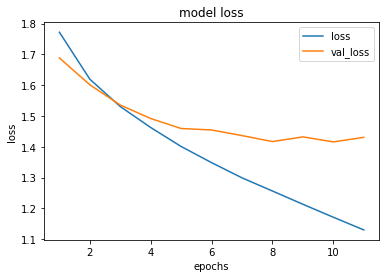

In [112]:
plt.plot(epochs,history_cnn3.history['acc'])
plt.plot(epochs,history_cnn3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(epochs,history_cnn3.history['loss'])
plt.plot(epochs,history_cnn3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [113]:
def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate = []
  for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
  y_pred = np.array(y_hate)
  
  classification_metrics = classification_report(y_test, y_pred)
  print(classification_metrics)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

              precision    recall  f1-score   support

           0       0.46      0.27      0.34       407
           1       0.33      0.16      0.22        37
           2       0.36      0.27      0.31       399
           3       0.68      0.73      0.70       732
           4       0.35      0.42      0.38       494
           5       0.60      0.59      0.60       300
           6       0.42      0.52      0.47       502

   micro avg       0.49      0.49      0.49      2871
   macro avg       0.46      0.43      0.43      2871
weighted avg       0.49      0.49      0.48      2871
 samples avg       0.49      0.49      0.49      2871



('F1: 0.4833647712701467',
 'precision: 0.4876076182740867',
 'recall: 0.49146638801811215')

Confusion matrix, without normalization


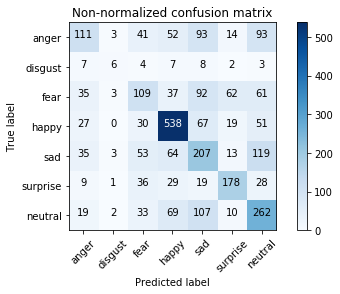

In [114]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_hat.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

## Transfer Learning (VGG16) 

In [135]:
x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers and standarize data
  list_pixels = [int(string)/255 for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)

x = np.array(x_train)
y = train_df.iloc[:,0]

In [136]:
# Categorize y to y category for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [137]:
print(x.shape) 
print(y.shape)

(28709, 48, 48)
(28709, 7)


In [138]:
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, \
                                          random_state = 123, test_size = 0.10)

In [139]:
print('x_test = ',x_test.shape)
print('y_test = ',y_test.shape)
print('training data  before splitting into train + validation :')
print('x_train1 = ',x_train1.shape)
print('y_train1 = ',y_train1.shape)

x_test =  (2871, 48, 48)
y_test =  (2871, 7)
training data  before splitting into train + validation :
x_train1 =  (25838, 48, 48)
y_train1 =  (25838, 7)


In [140]:
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [141]:
print('x_train = ',x_train.shape)
print('y_train = ', y_train.shape)
print('x_val = ',x_val.shape)
print('y_val = ', y_val.shape)

x_train =  (20670, 48, 48)
y_train =  (20670, 7)
x_val =  (5168, 48, 48)
y_val =  (5168, 7)


In [142]:
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)

In [143]:
x_train_reshaped = np.repeat(x_train_reshaped, 3, axis=3)
x_val_reshaped = np.repeat(x_val_reshaped, 3, axis=3)
x_test_reshaped = np.repeat(x_test_reshaped, 3, axis=3)

In [144]:
print(x_train_reshaped.shape)
print(x_val_reshaped.shape) 
print(x_test_reshaped.shape)

(20670, 48, 48, 3)
(5168, 48, 48, 3)
(2871, 48, 48, 3)


In [145]:
y_test.shape

(2871, 7)

## model 

In [146]:
# Set seed to get same results
np.random.seed(123)
cnn_base = VGG16(include_top= False, weights='imagenet', input_shape = (48,48,3))

In [147]:
# Define model as Sequential class
model_cnn4 = models.Sequential()

In [148]:
model_cnn4.add(cnn_base)
model_cnn4.add(layers.Flatten())
model_cnn4.add(layers.Dense(128, activation='tanh'))
model_cnn4.add(layers.Dense(64, activation='tanh'))
model_cnn4.add(layers.Dense(7, activation='softmax')) # 7 classification

In [149]:
model_cnn4.compile(loss='categorical_crossentropy',

                  optimizer="sgd",
              metrics=['acc'])

In [150]:
model_cnn4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 455       
Total params: 14,789,063
Trainable params: 14,789,063
Non-trainable params: 0
_________________________________________________________________


In [151]:
for layer in model_cnn4.layers[:16]:
   layer.trainable=False
for layer in model_cnn4.layers[16:]:
   layer.trainable=True

In [152]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.005,
                              patience=2,
                              verbose=0, mode='auto')

In [153]:

history_cnn4 = model_cnn4.fit(x_train_reshaped,
                    y_train,
                    epochs=15,
                    batch_size=10,
                    validation_data=(x_val_reshaped, y_val), callbacks= [earlystop])



C:\Users\Shoukkiya_Ashraf\miniconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 20670 samples, validate on 5168 samples
Epoch 1/15
20670/20670 [==============================] - 2420s 117ms/step - loss: 1.4428 - acc: 0.4402 - val_loss: 1.3529 - val_acc: 0.4942
Epoch 2/15
20670/20670 [==============================] - 2435s 118ms/step - loss: 1.1670 - acc: 0.5608 - val_loss: 1.1480 - val_acc: 0.5646
Epoch 3/15
20670/20670 [==============================] - 2484s 120ms/step - loss: 1.0405 - acc: 0.6075 - val_loss: 1.0842 - val_acc: 0.5882
Epoch 4/15
20670/20670 [==============================] - 2837s 137ms/step - loss: 0.9447 - acc: 0.6493 - val_loss: 1.1026 - val_acc: 0.5991
Epoch 5/15
20670/20670 [==============================] - 2537s 123ms/step - loss: 0.8420 - acc: 0.6886 - val_loss: 1.1174 - val_acc: 0.5985


### Evaluation 

In [155]:
# Evaluate train data
results_train_cnn = model_cnn4.evaluate(x_train_reshaped, y_train)
results_train_cnn

20670/20670 [==============================] - 486s 24ms/step


[0.736757374328868, 0.7234155535697937]

In [156]:
# Evaluate test data
results_test_cnn = model_cnn4.evaluate(x_test_reshaped, y_test)
results_test_cnn

2871/2871 [==============================] - 68s 24ms/step


[1.0883105667324193, 0.6081504821777344]

In [157]:
#saving the current best for future works
model_json = model_cnn4.to_json()
with open("VGG16_result", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_cnn4.save_weights("VGG16_result.h5")
print("Saved model to VGG16_result.h5 ")

Saved model to VGG16_result.h5 


### Plotting

In [159]:
y_hat4 = model_cnn4.predict(x_test_reshaped)

In [160]:
print(history_cnn4.history.keys())
epochs = range(1, len(history_cnn4.history['loss']) + 1)
print(epochs)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
range(1, 6)


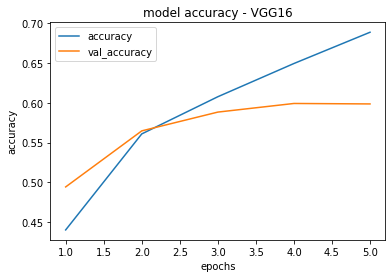

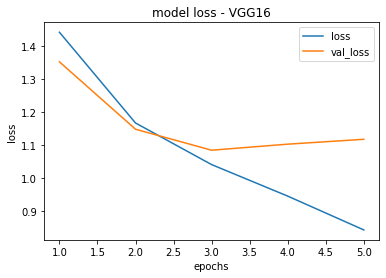

In [161]:
plt.plot(epochs,history_cnn4.history['acc'])
plt.plot(epochs,history_cnn4.history['val_acc'])
plt.title('model accuracy - VGG16')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(epochs,history_cnn4.history['loss'])
plt.plot(epochs,history_cnn4.history['val_loss'])
plt.title('model loss - VGG16')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [167]:
def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate4 = []
  for i in range(0,y_hat4.shape[0]):
    a = [1 if metric == y_hat4[i].max() else 0 for metric in y_hat4[i]]
    y_hate4.append(a)
  y_pred = np.array(y_hate4)
  
  classification_metrics = classification_report(y_test, y_pred)
  print(classification_metrics)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       407
           1       0.78      0.19      0.30        37
           2       0.39      0.43      0.41       399
           3       0.75      0.91      0.82       732
           4       0.61      0.36      0.46       494
           5       0.67      0.71      0.69       300
           6       0.58      0.54      0.56       502

   micro avg       0.61      0.61      0.61      2871
   macro avg       0.61      0.53      0.54      2871
weighted avg       0.61      0.61      0.60      2871
 samples avg       0.61      0.61      0.61      2871



('F1: 0.5970629620902691',
 'precision: 0.6057969835943539',
 'recall: 0.6081504702194357')

Confusion matrix, without normalization


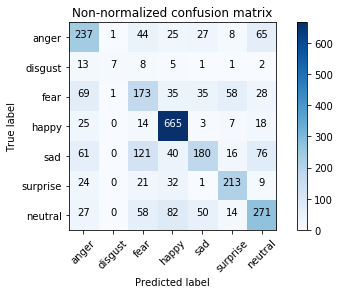

In [168]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_hat4.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

##  Transfer learning -VGG19 

In [4]:
# Reshape 1D array to 2D matrix for Conv2D

x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers and standarize data
  list_pixels = [int(string)/255 for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)

x = np.array(x_train)
y = train_df.iloc[:,0]

In [5]:
y.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

###### imbalance in value 

In [6]:
flag = 0
del_list = []
for i in range(len(y)):
    if y[i] == 1 :
        flag += 1
        del_list.append(i)
print(del_list)        

[299, 388, 416, 473, 533, 573, 758, 807, 826, 845, 864, 1073, 1096, 1115, 1265, 1270, 1310, 1542, 1619, 1661, 1777, 1843, 1975, 2005, 2151, 2163, 2275, 2321, 2389, 2419, 2542, 2625, 2695, 2732, 2742, 2746, 2787, 2795, 2844, 2939, 3063, 3101, 3195, 3286, 3292, 3347, 3516, 3521, 3561, 3626, 3690, 3758, 3778, 3865, 4002, 4004, 4078, 4088, 4265, 4312, 4448, 4481, 4537, 4587, 4706, 4737, 4805, 4882, 4889, 4897, 4908, 4969, 5085, 5168, 5197, 5203, 5328, 5335, 5377, 5667, 5692, 5785, 5830, 5958, 5964, 6145, 6177, 6229, 6231, 6331, 6342, 6422, 6454, 6488, 6548, 6562, 6638, 6780, 6867, 6878, 6926, 7049, 7068, 7108, 7143, 7192, 7313, 7386, 7405, 7455, 7468, 7503, 7592, 7597, 7704, 7733, 7835, 7837, 8155, 8218, 8315, 8353, 8379, 8415, 8416, 8509, 8512, 8573, 8585, 8628, 8675, 8692, 8726, 8823, 8877, 8893, 8948, 9023, 9043, 9090, 9145, 9159, 9189, 9204, 9297, 9343, 9366, 9460, 9464, 9472, 9504, 9612, 9654, 9679, 9695, 9716, 9733, 9738, 9844, 9913, 10018, 10022, 10053, 10112, 10137, 10236, 10316, 1

In [7]:
# Categorize y for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [8]:
print(x.shape)
print(y.shape)

(28709, 48, 48)
(28709, 7)


In [9]:
# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, \
                                          random_state = 123, test_size = 0.10)

In [10]:
print('x_test = ',x_test.shape)
print('y_test = ',y_test.shape)
print('training data  before splitting into train + validation :')
print('x_train1 = ',x_train1.shape)
print('y_train1 = ',y_train1.shape)

x_test =  (2871, 48, 48)
y_test =  (2871, 7)
training data  before splitting into train + validation :
x_train1 =  (25838, 48, 48)
y_train1 =  (25838, 7)


In [11]:
# Create train_test_split for validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [12]:
print('x_train = ',x_train.shape)
print('y_train = ', y_train.shape)
print('x_val = ',x_val.shape)
print('y_val = ', y_val.shape)

x_train =  (20670, 48, 48)
y_train =  (20670, 7)
x_val =  (5168, 48, 48)
y_val =  (5168, 7)


In [13]:
#need to do this because input_shape in model_cnn.add needs a 2D image with 
# depth specified as 1
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)

In [14]:
# Need to repeat our 48x48x1 to 3 dimensions, because transfer learning models take RGB format
x_train_reshaped = np.repeat(x_train_reshaped, 3, axis=3)
x_val_reshaped = np.repeat(x_val_reshaped, 3, axis=3)
x_test_reshaped = np.repeat(x_test_reshaped, 3, axis=3)


In [15]:
print(x_train_reshaped.shape)
print(x_val_reshaped.shape) 
print(x_test_reshaped.shape)

(20670, 48, 48, 3)
(5168, 48, 48, 3)
(2871, 48, 48, 3)


In [16]:
y_test.shape

(2871, 7)

### model 

In [20]:
np.random.seed(123)
# cnn_base = VGG16(include_top= False, weights='imagenet', input_shape = (48,48,3))
cnn_base = VGG19(include_top= False, weights='imagenet', input_shape = (48,48,3))

In [21]:
# Define model as Sequential class
model_cnn5 = models.Sequential() 

In [22]:
model_cnn5.add(cnn_base)

model_cnn5.add(layers.Flatten())
model_cnn5.add(layers.Dense(128, activation='tanh'))
model_cnn5.add(layers.Dense(64, activation='tanh'))
model_cnn5.add(layers.Dense(7, activation='softmax'))  # 7 classifications 

In [23]:
model_cnn5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 455       
Total params: 20,098,759
Trainable params: 20,098,759
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_cnn5.compile(loss='categorical_crossentropy',

                  optimizer="sgd",
              metrics=['acc'])


In [ ]:
# or if we want to set the first 19 layers of the network to be non-trainable
''''for layer in model_cnn.layers[:16]:
   layer.trainable=False
for layer in model_cnn.layers[16:]:
   layer.trainable=True
''''
    
# Note: tried running the freeze before compiling model. This yielded low accuracy scores
# Decided to compile model first, then freeze first 16 years (the VGG16 layers)

In [22]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.005,
                              patience=2,
                              verbose=0, mode='auto')

In [23]:
history_cnn5 = model_cnn5.fit(x_train_reshaped,
                    y_train,
                    epochs=15,
                    batch_size=10,
                    validation_data=(x_val_reshaped,
                                     y_val), callbacks= [earlystop])

Train on 20670 samples, validate on 5168 samples
Epoch 1/15
20670/20670 [==============================] - 3493s 169ms/step - loss: 1.4388 - acc: 0.4400 - val_loss: 1.3424 - val_acc: 0.4868
Epoch 2/15
20670/20670 [==============================] - 3784s 183ms/step - loss: 1.1825 - acc: 0.5550 - val_loss: 1.1590 - val_acc: 0.5608
Epoch 3/15
20670/20670 [==============================] - 3570s 173ms/step - loss: 1.0662 - acc: 0.6002 - val_loss: 1.1481 - val_acc: 0.5751
Epoch 4/15
20670/20670 [==============================] - 3871s 187ms/step - loss: 0.9741 - acc: 0.6351 - val_loss: 1.1643 - val_acc: 0.5842
Epoch 5/15
20670/20670 [==============================] - 3529s 171ms/step - loss: 0.8873 - acc: 0.6684 - val_loss: 1.1120 - val_acc: 0.5863
Epoch 6/15
20670/20670 [==============================] - 4338s 210ms/step - loss: 0.7907 - acc: 0.7133 - val_loss: 1.1088 - val_acc: 0.6024
Epoch 7/15
20670/20670 [==============================] - 3512s 170ms/step - loss: 0.7076 - acc: 0.7414 -

### Evaluation 

In [24]:
# Evaluate train data
results_train_cnn5 = model_cnn5.evaluate(x_train_reshaped, y_train)
results_train_cnn5

20670/20670 [==============================] - 616s 30ms/step


[0.44362462160952953, 0.8378326296806335]

In [25]:
# Evaluate test data
results_test_cnn5 = model_cnn5.evaluate(x_test_reshaped, y_test)
results_test_cnn5

2871/2871 [==============================] - 79s 28ms/step


[1.1900847770743401, 0.6325322389602661]

In [26]:
#saving the current best for future works
model_json = model_cnn5.to_json()
with open("VGG19_result", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_cnn5.save_weights("VGG19_result.h5")
print("Saved model to VGG19_result.h5 ")

Saved model to VGG19_result.h5 


### Plotting 

In [27]:
y_hat5 = model_cnn5.predict(x_test_reshaped)

In [28]:
print(history_cnn5.history.keys())
epochs = range(1, len(history_cnn5.history['loss']) + 1)
print(epochs)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
range(1, 10)


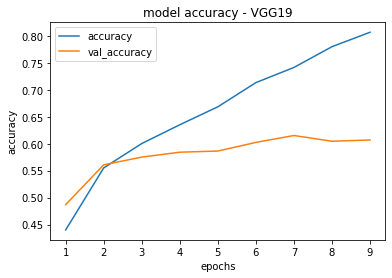

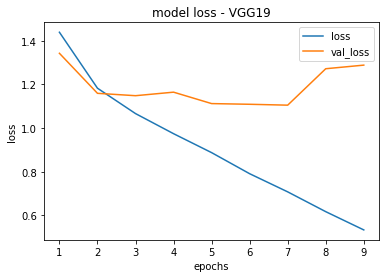

In [29]:
plt.plot(epochs,history_cnn5.history['acc'])
plt.plot(epochs,history_cnn5.history['val_acc'])
plt.title('model accuracy - VGG19')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(epochs,history_cnn5.history['loss'])
plt.plot(epochs,history_cnn5.history['val_loss'])
plt.title('model loss - VGG19')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [34]:
def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate5 = []
  for i in range(0,y_hat5.shape[0]):
    a = [1 if metric == y_hat5[i].max() else 0 for metric in y_hat5[i]]
    y_hate5.append(a)
  y_pred = np.array(y_hate5)
  
  classification_metrics = classification_report(y_test, y_pred)
  print(classification_metrics)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

              precision    recall  f1-score   support

           0       0.55      0.62      0.58       407
           1       0.45      0.54      0.49        37
           2       0.56      0.39      0.46       399
           3       0.83      0.80      0.81       732
           4       0.64      0.42      0.51       494
           5       0.71      0.73      0.72       300
           6       0.50      0.75      0.60       502

   micro avg       0.63      0.63      0.63      2871
   macro avg       0.61      0.61      0.60      2871
weighted avg       0.64      0.63      0.63      2871
 samples avg       0.63      0.63      0.63      2871



('F1: 0.6280141417584265',
 'precision: 0.6448985381477781',
 'recall: 0.6325322187391152')

In [35]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


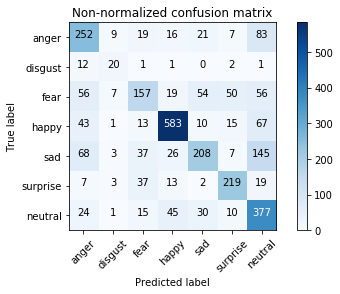

In [37]:
# Get Confusion matrix
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_hat5.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')